In [1]:
import torch

In [2]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
last_hidden_states.shape

torch.Size([1, 197, 768])

In [4]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Process Images

In [5]:
IMAGE_PATH = '/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead'

In [6]:
import os

In [9]:
dishes = [IMAGE_PATH + '/' + im + '/rgb.png' for im in  os.listdir(IMAGE_PATH)]

In [10]:
len(dishes)

3493

In [11]:
dishes[0]

'/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1556572657/rgb.png'

In [12]:
%%time

def get_embedding(im_path):
    image = Image.open(im_path)

    dish_name = im_path.split('/')[-2]

    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state[0, 0]
    return (dish_name, last_hidden_states)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [13]:
dish_name, embedding = get_embedding(dishes[0])

In [14]:
dish_name, embedding.size()

('dish_1556572657', torch.Size([768]))

# Get embeddings for images

Selected only those with at least 50 calories

In [15]:
from tqdm import tqdm

In [16]:
# embedding_dicts = {}

# for dish_path in tqdm(dishes):
#     try:
#         dish_name, embedding = get_embedding(dish_path)
#         embedding_dicts[dish_name] = embedding
#     except Exception as e:
#         print(e)

In [18]:
import pickle
# with open('embeddings_original.pickle', 'wb') as f:
#     pickle.dump(embedding_dicts, f)

In [25]:
with open('embeddings_original.pickle', 'rb') as f:
    embedding_dicts = pickle.load(f)

In [26]:
# generate in augment_images.ipynb
with open('embeddings_augmented.pickle', 'rb') as f:
    embedding_dict_blurred = pickle.load(f)

In [27]:
# Make sure that we have same set for both
embedding_dicts = dict([(d, embedding_dicts[d]) for d in embedding_dict_blurred.keys()])

In [28]:
len(embedding_dicts), len(embedding_dict_blurred)

(723, 723)

# Get true calories info

In [29]:
import pandas as pd

In [49]:
metadata = pd.read_csv('/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/metadata/dish_metadata_cafe1.csv', header=None, usecols=[0, 1, 2, 3, 4, 5])

In [50]:
metadata.columns = ['image', 'calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']

In [51]:
metadata = metadata[metadata['image'].isin(embedding_dicts.keys())]
metadata = metadata.sample(len(metadata)).reset_index(drop=True)

In [52]:
metadata.loc[:0.7*len(metadata), 'train_test'] = 'train'
metadata.loc[0.7*len(metadata):, 'train_test'] = 'test'

/tmp/ipykernel_19527/461955263.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.loc[:0.7*len(metadata), 'train_test'] = 'train'


In [53]:
metadata = metadata[metadata['calories'] > 50]

In [54]:
metadata

,image,calories,total_mass,total_fat,total_carb,total_protein,train_test
0,dish_1559846585,114.972008,201.0,0.201000,30.551998,0.804000,train
1,dish_1558722247,604.616028,343.0,43.181000,46.771999,21.490000,train
2,dish_1560360148,587.794006,317.0,33.510998,41.481003,29.463799,train
3,dish_1558458496,53.130001,77.0,0.154000,13.860001,0.539000,train
4,dish_1558630649,190.009995,355.0,0.710000,49.419998,2.005000,train
...,...,...,...,...,...,...,...
718,dish_1559239256,60.160000,128.0,0.128000,15.360000,1.152000,test
719,dish_1560368712,146.875183,142.0,12.029318,8.361059,3.578753,test
720,dish_1558115641,584.526001,331.0,34.696999,41.082001,27.196001,test
721,dish_1559844490,108.360001,180.0,0.459000,27.450001,1.359000,test


In [55]:
metadata_train = metadata[metadata['train_test'] == 'train']
metadata_test = metadata[metadata['train_test'] == 'test']

In [56]:
X_train, y_train = torch.concat([embedding_dicts[doc].unsqueeze(0) for doc in metadata_train['image']]), torch.Tensor(list(metadata_train['calories']))
X_train.shape, y_train.shape

(torch.Size([507, 768]), torch.Size([507]))

In [57]:
X_test, y_test = torch.concat([embedding_dicts[doc].unsqueeze(0) for doc in metadata_test['image']]), torch.Tensor(list(metadata_test['calories']))
X_test.shape, y_test.shape

(torch.Size([216, 768]), torch.Size([216]))

# Train ML model

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_fresh_model(X_train, y_train):
    # Assuming `n_features` is the number of features in your input data
    n_features = X_train.shape[1]
    
    class SimpleMLP(nn.Module):
        def __init__(self, n_features):
            super(SimpleMLP, self).__init__()
            # Define the single regression head (linear layer without activation)
            self.regression_head = nn.Linear(n_features, 1)
            self.reLU = nn.ReLU()
    
        def forward(self, x):
            x = self.regression_head(x)
            x = self.reLU(x)
            return x
    
    # Create an instance of the model
    model_regression = SimpleMLP(n_features=n_features)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model_regression.parameters(), lr=0.1)

    n_epochs = 200
    for epoch in range(n_epochs):
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model_regression(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))  # Reshape y_train to match the output shape
    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
        # Print statistics
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    return model_regression

In [64]:
model_regression = train_fresh_model(X_train, y_train)

Epoch [1/200], Loss: 95480.4531
Epoch [11/200], Loss: 18555.5801
Epoch [21/200], Loss: 14144.1553
Epoch [31/200], Loss: 11977.2051
Epoch [41/200], Loss: 10624.6836
Epoch [51/200], Loss: 9677.5801
Epoch [61/200], Loss: 8961.3975
Epoch [71/200], Loss: 8389.7646
Epoch [81/200], Loss: 7917.0708
Epoch [91/200], Loss: 7514.1313
Epoch [101/200], Loss: 7165.1948
Epoch [111/200], Loss: 6858.7495
Epoch [121/200], Loss: 6586.4199
Epoch [131/200], Loss: 6342.0601
Epoch [141/200], Loss: 6121.0181
Epoch [151/200], Loss: 5919.6846
Epoch [161/200], Loss: 5735.2041
Epoch [171/200], Loss: 5564.4971
Epoch [181/200], Loss: 5406.3970
Epoch [191/200], Loss: 5259.6992


# Predictions on test

In [65]:
y_test_pred = model_regression(X_test).squeeze(-1).detach()

In [71]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [72]:
def get_metrics(y_test, y_test_pred):
    return {'MAE': mean_absolute_error(y_test.detach().numpy(), y_test_pred),
            'MAPE': mean_absolute_percentage_error(y_test.detach().numpy(), y_test_pred),
            'R2': r2_score(y_test.detach().numpy(), y_test_pred)}

In [73]:
get_metrics(y_test, y_test_pred)

{'MAE': 71.50489, 'MAPE': 0.4278351, 'R2': 0.7047802067002613}

In [74]:
y_test_pred[:20]

tensor([ 55.7923, 162.3875, 520.3551, 173.3563, 192.2802,  63.7323, 103.7066,
        162.5175, 378.3434, 323.6147, 340.5573, 271.5541, 486.7278, 322.3315,
        402.7735, 139.6838,  89.5497, 130.2565, 121.2767,  35.5590])

In [75]:
y_test[:20]

tensor([ 87.6300, 113.9100, 199.3480,  76.5900, 197.3779,  88.3500,  61.0899,
        132.9630, 208.1160, 313.5860, 121.4010, 162.2300, 687.9390, 334.4830,
        450.5614,  92.4600,  68.1800, 102.8256, 153.8460, 130.9200])

# Add Text Embeddings and train again

### Use GPT-4 to simulate an elder person

In [413]:
MSG = \
"""
Pretend that you are an elderly person.
This is a picture of food taken by You. This picture shows your current meal. Your role is to provide description what you eat in your own words.
Describe the ingredients, how much you use of them, and how it's prepared. Do it in one sentence, using keywords, possibly short.
"""

In [420]:
import matplotlib.pyplot as plt

In [415]:
import base64
import requests

# OpenAI API Key
api_key = ""

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = dish_path

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [416]:
payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": MSG
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 100
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-94zhrosyZiWWvzXOTHc7OM6oSs8E3', 'object': 'chat.completion', 'created': 1710977539, 'model': 'gpt-4-1106-vision-preview', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Kale sautéed with garlic and olive oil, a slice of homemade lasagna with layers of pasta, ricotta, mozzarella, parmesan, ground meat, tomato sauce, baked until bubbly and golden.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 503, 'completion_tokens': 46, 'total_tokens': 549}, 'system_fingerprint': None}


In [455]:
def get_description_from_gpt4(img_path):
    base64_image = encode_image(img_path)
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": MSG
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
      ],
      "max_tokens": 100
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    print(response)
    
    return response.json()['choices'][0]['message']['content']

In [459]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.2/851.2 kB 7.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 17.1 MB/s eta 0:00:00
Using cached h11-0.14.0-py3-none-any.whl (58 kB)


In [476]:
import anthropic
import base64

def get_description_from_claude(img_path):
    with open(img_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf8')

    client = anthropic.Anthropic(
        # defaults to os.environ.get("ANTHROPIC_API_KEY")
        api_key="",
    )
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=100,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Pretend that you are an elderly person.\nThis is a picture of food taken by You. This picture shows your current meal. Your role is to provide description what you eat in your own words.\nDescribe the ingredients, how much you use of them, and how it's prepared. Do it in one sentence, using keywords, possibly short."
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": base64_image
                        }
                    }
                ]
            }
        ]
    )
    return message.content[0].text

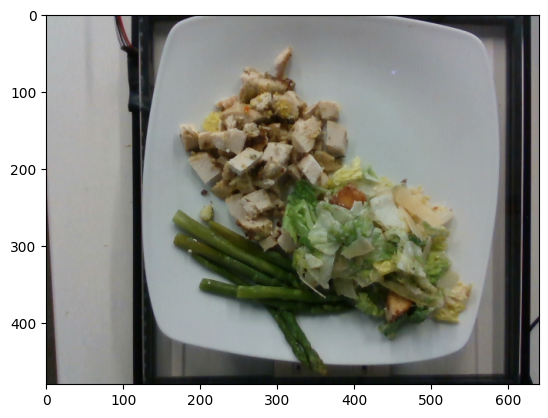

In [468]:
plt.imshow(Image.open(image_path))

In [422]:
%%time
get_description_from_gpt4(image_path)

CPU times: user 99.9 ms, sys: 18 µs, total: 99.9 ms
Wall time: 5.86 s


'Cheese-topped lasagna with layers of pasta, ricotta, tomato sauce, ground beef; a side of steamed kale, seasoned with a pinch of salt and a drizzle of olive oil.'

In [465]:
base64_image[:10]

'iVBORw0KGg'

In [469]:
image_path

'/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1559590157/rgb.png'

In [477]:
%%time
get_description_from_claude(image_path)

CPU times: user 73.8 ms, sys: 3.87 ms, total: 77.6 ms
Wall time: 10.6 s


'Chicken, potatoes, green beans, lettuce - boiled and fried, small portions.'

In [424]:
# 6000 images

In [425]:
metadata

,image,calories,train_test
1,dish_1559849537,549.523010,train
2,dish_1560443537,237.639999,train
3,dish_1558116436,91.970001,train
4,dish_1558109986,258.450012,train
5,dish_1558637896,84.870003,train
...,...,...,...
1031,dish_1557936555,149.279999,test
1032,dish_1558381840,113.849998,test
1034,dish_1558546558,254.364014,test
1035,dish_1560526472,113.672775,test


In [430]:
dishes_to_process = [IMAGE_PATH + '/' + im + '/rgb.png' for im in metadata['image']]

In [431]:
len(dishes_to_process)

723

In [435]:
gpt4 = pd.read_csv('gpt4_350.csv')

In [478]:
gpt4

,image_name,description
0,dish_1559849537,"I'm having a simple, healthy snack with a hand..."
1,dish_1560443537,"Fresh fruit salad, hand-picked raspberries, bl..."
2,dish_1558116436,"Crispy bacon, two strips, pan-fried, simple an..."
3,dish_1558109986,"I'm enjoying a simple meal of sliced, pan-frie..."
4,dish_1558637896,"A simple, healthy snack of a handful of assort..."
...,...,...
346,dish_1560798707,That's a slice of cheese lasagna with a bit of...
347,dish_1559678104,A simple salad with fresh red and green lettuc...
348,dish_1560360112,"Scrambled eggs with cheese, sprinkle of salt, ..."
349,dish_1559842047,"Fresh fruit and steamed broccoli, simple and w..."


In [438]:
dishes_to_process[349]

'/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1559842047/rgb.png'

In [479]:
descriptions = []

for i, (image_path, image_name) in tqdm(enumerate(zip(dishes_to_process[350:], list(metadata['image'])[350:])), total=len(dishes_to_process)):
    try:
        # description = get_description_from_gpt4(image_path)
        description = get_description_from_claude(image_path)
        descriptions.append({'image_name': image_name, 'description': description})

    except Exception as e:
        print(e)


    if i%50 == 0:
        pd.DataFrame(descriptions).to_csv(f'gpt4_2_{i}.csv', index=False)

 52%|████████████████████████████████████████████████████████████████████                                                                | 373/723 [56:30<53:01,  9.09s/it]


In [483]:
descriptions = pd.concat([gpt4, pd.DataFrame(descriptions)])
descriptions.to_csv('description.csv')

# Get embeddings of text description

In [76]:
dataset = pd.read_csv('description_with_embeddings.csv')[['image_name', 'description', 'embedding']]

In [77]:
dataset_merged = pd.merge(dataset, metadata, left_on=['image_name'], right_on=['image'])

In [78]:
dataset_merged

,image_name,description,embedding,image,calories,total_mass,total_fat,total_carb,total_protein,train_test
0,dish_1559849537,"I'm having a simple, healthy snack with a hand...","[0.0072064949199557304, 0.03340759128332138, -...",dish_1559849537,549.523010,393.0,30.711000,65.328995,15.438001,train
1,dish_1560443537,"Fresh fruit salad, hand-picked raspberries, bl...","[0.012388301081955433, 0.0289766788482666, -0....",dish_1560443537,237.639999,411.0,0.913000,60.169998,2.651000,test
2,dish_1558116436,"Crispy bacon, two strips, pan-fried, simple an...","[0.027798837050795555, -0.03318409621715546, -...",dish_1558116436,91.970001,17.0,7.140000,0.238000,6.290000,train
3,dish_1558109986,"I'm enjoying a simple meal of sliced, pan-frie...","[0.030582459643483162, -0.0088918162509799, -0...",dish_1558109986,258.450012,75.0,20.475000,3.150000,14.475000,test
4,dish_1558637896,"A simple, healthy snack of a handful of assort...","[0.017888465896248817, -0.0057890587486326694,...",dish_1558637896,84.870003,123.0,0.246000,22.140001,0.861000,train
...,...,...,...,...,...,...,...,...,...,...
719,dish_1557936555,"Scrambled eggs, two, microwave.","[-0.002091321162879467, -0.030263222754001617,...",dish_1557936555,149.279999,96.0,10.080000,1.152000,12.000000,train
720,dish_1558381840,"Oatmeal, milk, banana slices, walnuts; microwa...","[-0.005124344490468502, -0.027453262358903885,...",dish_1558381840,113.849998,69.0,2.484000,0.000000,21.389999,test
721,dish_1558546558,"Handful of almonds, raw, unsalted, about 20-25...","[-0.012985984794795513, 0.012175682000815868, ...",dish_1558546558,254.364014,44.0,21.780001,9.988000,9.856000,test
722,dish_1560526472,"Spinach, tomatoes, olives, lettuce - a handful...","[0.023701202124357224, 0.008757668547332287, -...",dish_1560526472,113.672775,114.0,8.288130,9.571251,2.058025,test


In [79]:
dataset_merged_train = dataset_merged[dataset_merged['train_test'] == 'train']
dataset_merged_test = dataset_merged[dataset_merged['train_test'] == 'test']

In [80]:
X_train_image, y_train = torch.concat([embedding_dicts[doc].unsqueeze(0) for doc in dataset_merged_train['image']]), torch.Tensor(list(dataset_merged_train['calories']))
X_train_image.shape, y_train.shape

(torch.Size([508, 768]), torch.Size([508]))

In [81]:
X_test_image, y_test = torch.concat([embedding_dicts[doc].unsqueeze(0) for doc in dataset_merged_test['image']]), torch.Tensor(list(dataset_merged_test['calories']))
X_test_image.shape, y_test.shape

(torch.Size([216, 768]), torch.Size([216]))

In [82]:
X_train_text = torch.concat([torch.tensor(eval(e)).unsqueeze(0) for e in dataset_merged_train['embedding']])
X_test_text = torch.concat([torch.tensor(eval(e)).unsqueeze(0) for e in dataset_merged_test['embedding']])

In [83]:
X_train_text.shape, X_test_text.shape

(torch.Size([508, 3072]), torch.Size([216, 3072]))

In [84]:
X_train_combined = torch.concat([X_train_image, X_train_text], dim=-1)
X_test_combined = torch.concat([X_test_image, X_test_text], dim=-1)
X_train_combined.shape

torch.Size([508, 3840])

In [86]:
# Create an instance of the model
model_regression_combined = train_fresh_model(X_train_combined, y_train)
y_test_pred = model_regression_combined(X_test_combined).squeeze(-1).detach()
get_metrics(y_test, y_test_pred)

Epoch [1/200], Loss: 95316.7891
Epoch [11/200], Loss: 18511.9883
Epoch [21/200], Loss: 13756.0098
Epoch [31/200], Loss: 11574.6230
Epoch [41/200], Loss: 10219.3955
Epoch [51/200], Loss: 9267.5752
Epoch [61/200], Loss: 8542.7510
Epoch [71/200], Loss: 7963.7583
Epoch [81/200], Loss: 7483.9468
Epoch [91/200], Loss: 7075.9971
Epoch [101/200], Loss: 6722.5571
Epoch [111/200], Loss: 6411.5586
Epoch [121/200], Loss: 6134.0479
Epoch [131/200], Loss: 5885.0884
Epoch [141/200], Loss: 5659.9009
Epoch [151/200], Loss: 5454.8193
Epoch [161/200], Loss: 5266.9478
Epoch [171/200], Loss: 5093.9673
Epoch [181/200], Loss: 4933.9829
Epoch [191/200], Loss: 4785.4297


{'MAE': 69.411316, 'MAPE': 0.4145754, 'R2': 0.7158189921124453}

In [595]:
# 32.4% to 31%

# What when images are blurred

In [87]:
X_test, y_test = torch.concat([embedding_dict_blurred[doc].unsqueeze(0) for doc in metadata_test['image']]), torch.Tensor(list(metadata_test['calories']))
X_test.shape, y_test.shape

(torch.Size([216, 768]), torch.Size([216]))

In [88]:
X_test_image, y_test = torch.concat([embedding_dict_blurred[doc].unsqueeze(0) for doc in dataset_merged_test['image']]), torch.Tensor(list(dataset_merged_test['calories']))
X_test_combined = torch.concat([X_test_image, X_test_text], dim=-1)
X_test_combined.shape, y_test.shape

(torch.Size([216, 3840]), torch.Size([216]))

In [89]:
y_pred_no_text = model_regression(X_test).squeeze(-1).detach()
y_pred_combined = model_regression_combined(X_test_combined).squeeze(-1).detach()

In [90]:
get_metrics(y_test, y_pred_no_text)

{'MAE': 196.3876, 'MAPE': 1.3004206, 'R2': -0.9233370596672206}

In [91]:
get_metrics(y_test, y_pred_combined)

{'MAE': 83.44455, 'MAPE': 0.5454347, 'R2': 0.6417662787267214}

# What if we use text only

In [93]:
X_train_text = torch.concat([torch.tensor(eval(e)).unsqueeze(0) for e in dataset_merged_train['embedding']])
X_test_text = torch.concat([torch.tensor(eval(e)).unsqueeze(0) for e in dataset_merged_test['embedding']])

model_regression_text = train_fresh_model(X_train_text, y_train)
y_test_pred = model_regression_text(X_test_text).squeeze(-1).detach()
get_metrics(y_test, y_test_pred)

Epoch [1/200], Loss: 95320.6484
Epoch [11/200], Loss: 37058.8750
Epoch [21/200], Loss: 35499.5508
Epoch [31/200], Loss: 34223.2266
Epoch [41/200], Loss: 33076.2344
Epoch [51/200], Loss: 32042.2930
Epoch [61/200], Loss: 31107.4766
Epoch [71/200], Loss: 30259.7422
Epoch [81/200], Loss: 29488.6523
Epoch [91/200], Loss: 28785.1602
Epoch [101/200], Loss: 28141.4160
Epoch [111/200], Loss: 27550.5840
Epoch [121/200], Loss: 27006.7266
Epoch [131/200], Loss: 26504.6621
Epoch [141/200], Loss: 26039.8691
Epoch [151/200], Loss: 25608.4062
Epoch [161/200], Loss: 25206.8027
Epoch [171/200], Loss: 24832.0293
Epoch [181/200], Loss: 24481.4258
Epoch [191/200], Loss: 24152.6445


{'MAE': 105.9728, 'MAPE': 0.72006327, 'R2': 0.3583404125415981}

# Real world case

In [128]:
from openai import OpenAI
client = OpenAI(api_key="")

def get_embedding(text, model="text-embedding-3-large"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [159]:
image_real = Image.open("super_nutricious.jpeg")

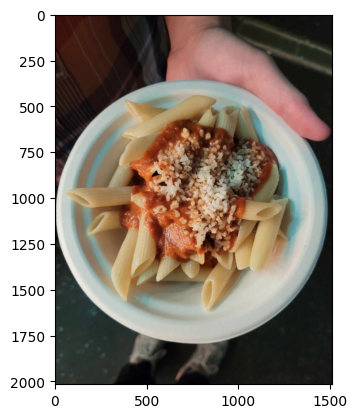

In [161]:
import matplotlib.pyplot as plt
plt.imshow(image_real)

In [124]:
inputs = processor(images=image_real, return_tensors="pt")

# get vision embedding
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state[0, 0]

# get text embedding
text_embedding = get_embedding("This is a medium bowl of pasta, with tomato sauce and a spoon of parmesan cheese on top")

# run combined head
prediction = model_regression_combined(torch.concat([last_hidden_states.unsqueeze(0), torch.tensor(text_embedding).unsqueeze(0)], dim=-1))

In [162]:
prediction

tensor([[413.8978]], grad_fn=<ReluBackward0>)

In [166]:
# 200g of cooked pasta = 262
# 100g of tomato sauce = 74
# 20g of cheese = 86
262 + 74 + 86

422

# Train combined model for macronutrients

In [94]:
y_train_fat = torch.Tensor(list(dataset_merged_train['total_fat']))
y_test_fat = torch.Tensor(list(dataset_merged_test['total_fat']))

In [109]:
model_fat = train_fresh_model(X_train_combined, y_train_fat)
y_test_pred = model_fat(X_test_combined).squeeze(-1).detach()
get_metrics(y_test_fat[y_test_fat > 0], y_test_pred[y_test_fat > 0])

Epoch [1/200], Loss: 443.2501
Epoch [11/200], Loss: 99.2030
Epoch [21/200], Loss: 78.9857
Epoch [31/200], Loss: 68.6357
Epoch [41/200], Loss: 61.8643
Epoch [51/200], Loss: 56.8712
Epoch [61/200], Loss: 52.9705
Epoch [71/200], Loss: 49.7505
Epoch [81/200], Loss: 47.0061
Epoch [91/200], Loss: 44.6262
Epoch [101/200], Loss: 42.5198
Epoch [111/200], Loss: 40.6515
Epoch [121/200], Loss: 38.9748
Epoch [131/200], Loss: 37.4568
Epoch [141/200], Loss: 36.0721
Epoch [151/200], Loss: 34.7948
Epoch [161/200], Loss: 33.6181
Epoch [171/200], Loss: 32.5291
Epoch [181/200], Loss: 31.5168
Epoch [191/200], Loss: 30.5551


{'MAE': 5.3682528, 'MAPE': 3.0339043, 'R2': 0.7203848338377832}

In [110]:
y_train_protein = torch.Tensor(list(dataset_merged_train['total_protein']))
y_test_protein = torch.Tensor(list(dataset_merged_test['total_protein']))

model_protein = train_fresh_model(X_train_combined, y_train_protein)
y_test_pred = model_protein(X_test_combined).squeeze(-1).detach()
get_metrics(y_test_protein[y_test_protein > 0], y_test_pred[y_test_protein > 0])

Epoch [1/200], Loss: 328.3291
Epoch [11/200], Loss: 97.7533
Epoch [21/200], Loss: 76.2273
Epoch [31/200], Loss: 64.9491
Epoch [41/200], Loss: 57.3803
Epoch [51/200], Loss: 51.7088
Epoch [61/200], Loss: 47.2126
Epoch [71/200], Loss: 43.5137
Epoch [81/200], Loss: 40.4087
Epoch [91/200], Loss: 37.7644
Epoch [101/200], Loss: 35.4759
Epoch [111/200], Loss: 33.4745
Epoch [121/200], Loss: 31.7073
Epoch [131/200], Loss: 30.1308
Epoch [141/200], Loss: 28.7114
Epoch [151/200], Loss: 27.4285
Epoch [161/200], Loss: 26.2628
Epoch [171/200], Loss: 25.1979
Epoch [181/200], Loss: 24.2184
Epoch [191/200], Loss: 23.3141


{'MAE': 5.828869, 'MAPE': 1.87903, 'R2': 0.6224435840511107}

In [111]:
y_train_carb = torch.Tensor(list(dataset_merged_train['total_carb']))
y_test_carb = torch.Tensor(list(dataset_merged_test['total_carb']))

model_carb = train_fresh_model(X_train_combined, y_train_carb)
y_test_pred = model_carb(X_test_combined).squeeze(-1).detach()
get_metrics(y_test_carb[y_test_carb > 0], y_test_pred[y_test_carb > 0])

Epoch [1/200], Loss: 654.0867
Epoch [11/200], Loss: 128.7533
Epoch [21/200], Loss: 81.3271
Epoch [31/200], Loss: 65.5002
Epoch [41/200], Loss: 56.3650
Epoch [51/200], Loss: 50.1083
Epoch [61/200], Loss: 45.4982
Epoch [71/200], Loss: 41.9052
Epoch [81/200], Loss: 39.0133
Epoch [91/200], Loss: 36.6114
Epoch [101/200], Loss: 34.5676
Epoch [111/200], Loss: 32.7914
Epoch [121/200], Loss: 31.2294
Epoch [131/200], Loss: 29.8351
Epoch [141/200], Loss: 28.5807
Epoch [151/200], Loss: 27.4454
Epoch [161/200], Loss: 26.4108
Epoch [171/200], Loss: 25.4628
Epoch [181/200], Loss: 24.5899
Epoch [191/200], Loss: 23.7827


{'MAE': 7.47889, 'MAPE': 0.8201142, 'R2': 0.5249665849091878}

# Create cool plots

In [114]:
# 3 models: Image only, Trained on text, Trained on both
# 2 cases
# metrics: R2, MAPE, MAE

In [126]:
results = [
    {'test_data': 'original', 'model': 'Image only', 'MAE': 71.50489, 'MAPE': 0.4278351, 'R2': 0.70},
    {'test_data': 'original', 'model': 'Text only', 'MAE': 105.9728, 'MAPE': 0.72006327, 'R2': 0.3583404125415981},
    {'test_data': 'original', 'model': 'Multimodal', 'MAE': 69.411316, 'MAPE': 0.4145754, 'R2': 0.71581},
    {'test_data': 'augmented', 'model': 'Image only', 'MAE': 196.3876, 'MAPE': 1.3004206, 'R2': -0.9233},
    {'test_data': 'augmented', 'model': 'Text only', 'MAE': 105.9728, 'MAPE': 0.72006327, 'R2': 0.3583404},
    {'test_data': 'augmented', 'model': 'Multimodal', 'MAE': 83.44455, 'MAPE': 0.5454347, 'R2': 0.64176627},
]

In [127]:
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns
import pandas as pd

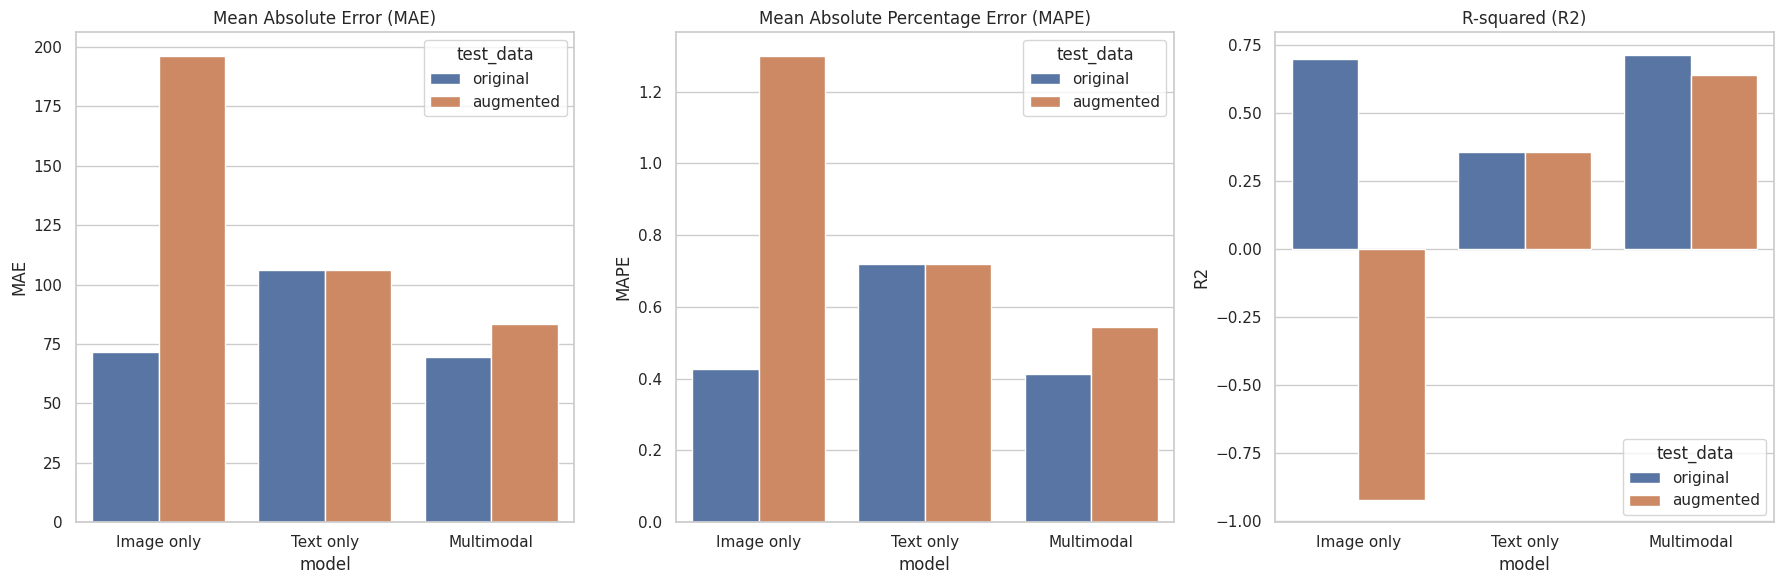

In [135]:
results_df = pd.DataFrame(results)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Create a barplot for each metric
sns.barplot(
    x="model", y="MAE", hue="test_data",
    data=results_df, ax=axes[0]
)
axes[0].set_title('Mean Absolute Error (MAE)')

sns.barplot(
    x="model", y="MAPE", hue="test_data",
    data=results_df, ax=axes[1]
)
axes[1].set_title('Mean Absolute Percentage Error (MAPE)')

sns.barplot(
    x="model", y="R2", hue="test_data",
    data=results_df, ax=axes[2]
)
axes[2].set_title('R-squared (R2)')

# Final touches and showing the plot
plt.tight_layout()
plt.show()

In [132]:
df_melted

,test_data,model,Metric,Value,Normalized Value
0,original,Image only,MAE,71.504890,0.364101
1,original,Text only,MAE,105.972800,0.539610
2,original,Multimodal,MAE,69.411316,0.353440
3,augmented,Image only,MAE,196.387600,1.000000
4,augmented,Text only,MAE,105.972800,0.539610
5,augmented,Multimodal,MAE,83.444550,0.424897
6,original,Image only,MAPE,0.427835,0.328997
7,original,Text only,MAPE,0.720063,0.553716
8,original,Multimodal,MAPE,0.414575,0.318801
9,augmented,Image only,MAPE,1.300421,1.000000
